<a href="https://colab.research.google.com/github/CynthiaGichuki/Early-DR-Detection-Classification/blob/main/ENSEMBLE_INCEPTIONV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INCEPTIONV3 MODEL - BASE MODEL 2

In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 1.0
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


IMPORT THE NECESSARY LIBRARIES

In [ ]:
import tensorflow as tf
from zipfile import ZipFile
import os, glob
import cv2
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Dense,MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator


DATA AUGMENTATION

In [ ]:
pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import Augmentor

In [ ]:
p = Augmentor.Pipeline("/content/drive/MyDrive/WHOLEDATASET",output_directory = "/content/drive/MyDrive/Augmented3")

Initialised with 10125 image(s) found.
Output directory set to /content/drive/MyDrive/Augmented3.

In [ ]:
#p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)

In [ ]:
#p.zoom(probability=0.3, min_factor=1.1, max_factor=1.6)

In [ ]:
#p.sample(15000)

DATA PREPARATION

In [ ]:

classes = {'grade_0': 0, 'grade_1':1, 'grade_2':2, 'grade_3':3}

X = []
Y = []
for cls in classes:
  pth = '/content/drive/MyDrive/Augmented3/'+cls
  for j in os.listdir(pth):
    img = cv2.imread(pth+'/'+j)
    #cv2_imshow(img)
    try:
       img = cv2.resize(img, (224,224))

       #img = cv2.GaussianBlur(img,(10,10),0)
       X.append(img)
       Y.append(classes[cls])
    except Exception as e:
      pass

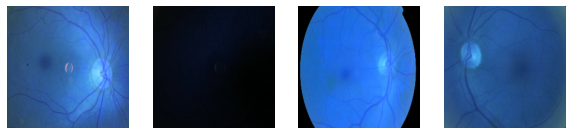

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(X[i], cmap="gray")
    plt.axis('off')
plt.show()

DATA SPLITTING

In [ ]:
xtrain, xtest, ytrain, ytest =  train_test_split(X, Y, test_size=.20, random_state=42)

In [ ]:
np.unique(Y)

array([0, 1, 2, 3])

In [ ]:
import pandas as pd
pd.Series(Y).value_counts()

0    4644
1    3916
2    3891
3    2549
dtype: int64

In [ ]:
le = preprocessing.LabelEncoder()
ytrain = le.fit_transform(ytrain)
ytest = le.fit_transform(ytest)
ytrain = tf.keras.utils.to_categorical(ytrain, num_classes=4)
ytest = tf.keras.utils.to_categorical(ytest, num_classes=4)
ytrain = np.array(ytrain)
xtrain = np.array(xtrain)
ytest = np.array(ytest)
xtest = np.array(xtest)
print("X_train Shape: ", xtrain.shape)
print("X_test Shape: ", xtest.shape)
print("y_train Shape: ", ytrain.shape)
print("y_test Shape: ", ytest.shape)

X_train Shape:  (12000, 224, 224, 3)
X_test Shape:  (3000, 224, 224, 3)
y_train Shape:  (12000, 4)
y_test Shape:  (3000, 4)


INCEPTIONV3 MODEL

In [ ]:
from keras.applications import InceptionV3


img_rows, img_cols = 224, 224


inception = InceptionV3(weights = 'imagenet',
                 include_top = False,
                 input_shape = (img_rows, img_cols, 3))

# Here we freeze the last 4 layers
# Layers are set to trainable as True by default
for layer in inception.layers:
    layer.trainable = False

for (i,layer) in enumerate(inception.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 Conv2D False
2 BatchNormalization False
3 Activation False
4 Conv2D False
5 BatchNormalization False
6 Activation False
7 Conv2D False
8 BatchNormalization False
9 Activation False
10 MaxPooling2D False
11 Conv2D False
12 BatchNormalization False
13 Activation False
14 Conv2D False
15 BatchNormalization False
16 Activation False
17 MaxPooling2D False
18 Conv2D False
19 BatchNormalization False
20 Activation False
21 Conv2D False
22 Conv2D False
23 BatchNormalization False
24 BatchNormalization False
25 Activation False
26 Activation False
27 AveragePooling2D False
28 Conv2D False
29 Conv2D False
30 Conv2D False
31 Conv2D False
32 BatchNormalization False
33 BatchNormalization False
34 BatchNormalization False
35 BatchNormalization False
36 Activation False
37 Activation False
38 Activation False
39 Activation False
40 Concatenate False
41 Conv2D False
42 BatchNormalization False
43 Activation False
44 Conv2D False
45 Conv2D False
46 BatchNormalization False
47 Batc

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras import regularizers

def lw(bottom_model, num_classes):
    """creates the top or head of the model that will be
    placed ontop of the bottom layers"""

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    #top_model = Dense(128,activation='relu',kernel_regularizer=regularizers.l2(0.000001))(top_model)
    top_model = Dense(128,activation='relu')(top_model)
    #top_model = Dropout(0.5)(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model



In [ ]:
from keras.models import Model


num_classes = 4

FC_Head = lw(inception, num_classes)

model2 = Model(inputs = inception.input, outputs = FC_Head)

print(model2.summary())

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_188 (Conv2D)            (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_188 (Batch  (None, 111, 111, 32  96         ['conv2d_188[0][0]']             
 Normalization)                 )                                                          

In [ ]:
from keras.optimizers import SGD

model2.compile(optimizer=SGD(learning_rate=0.01), loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

model_filepath = '/content/drive/MyDrive/Model/Model-{epoch:02d}={val_accuracy:.4f}.hdf5'
checkpoint = ModelCheckpoint(
    filepath=model_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

In [ ]:
history = model2.fit(xtrain,ytrain,
                    epochs=50,callbacks=[checkpoint],
                    validation_data=(xtest,ytest),
                    verbose = 1,
                    initial_epoch=0)

Epoch 1/50
375/375 [==============================] - ETA: 0s - loss: 4.2198 - accuracy: 0.2982
Epoch 1: val_accuracy improved from -inf to 0.30333, saving model to /content/drive/MyDrive/Model/Model-01=0.3033.hdf5
375/375 [==============================] - 135s 346ms/step - loss: 4.2198 - accuracy: 0.2982 - val_loss: 1.3641 - val_accuracy: 0.3033
Epoch 2/50
375/375 [==============================] - ETA: 0s - loss: 1.3571 - accuracy: 0.3010
Epoch 2: val_accuracy did not improve from 0.30333
375/375 [==============================] - 127s 339ms/step - loss: 1.3571 - accuracy: 0.3010 - val_loss: 1.3581 - val_accuracy: 0.2947
Epoch 3/50
375/375 [==============================] - ETA: 0s - loss: 1.3556 - accuracy: 0.3102
Epoch 3: val_accuracy improved from 0.30333 to 0.31600, saving model to /content/drive/MyDrive/Model/Model-03=0.3160.hdf5
375/375 [==============================] - 128s 342ms/step - loss: 1.3556 - accuracy: 0.3102 - val_loss: 1.3568 - val_accuracy: 0.3160
Epoch 4/50
375/

In [ ]:
#import matplotlib.pyplot as plt
#acc = history2.history['accuracy']
#val_acc = history2.history['val_accuracy']
#loss = history2.history['loss']
#val_loss = history2.history['val_loss']


#epochs = range(len(acc))

#plt.plot(epochs, acc, 'r', label='Training Accuracy')
#plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
#plt.title('Training and validation accuracy')
#plt.legend()
#plt.figure()

#plt.plot(epochs, loss, 'r', label='Training Loss')
#plt.plot(epochs, val_loss, 'b', label='Validation Loss')
#plt.title('Training and validation loss')
#plt.legend()

#plt.show()

In [ ]:
#from tensorflow.keras.models import Model, load_model
#from tensorflow.keras.layers import Input, Average
#model_1 = load_model('/content/drive/MyDrive/Model-01=0.3113.hdf5')
#model_1 = Model(input=model_1.inputs,
 #               outputs=model_1.outputs,
  #              name='name_of_model_1')

#model_2 = load_model('/content/drive/MyDrive/Model-01=0.3113.hdf5')
#model_2 = Model(input=model_2.inputs,
 #               outputs=model2.outputs,
  #              name='name_of_model_2')

#models = [model_1, model_2]
#model_input = Input(shape=(220, 220, 3))
#model_outputs = [model(model_input) for model in models]
#ensemble_output = Average()(model_outputs)
#ensemble_model = Model(inputs=model_input, outputs=ensemble_output, name='ensemble')

In [ ]:
#ensemble_model.compile(optimizer='adam', loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [ ]:
#history=ensemble_model.fit(
 #   train_ds,
  #  validation_data=val_ds,
   # epochs=30
#)

In [ ]:
#import matplotlib.pyplot as plt
#acc = history.history['accuracy']
#val_acc = history.history['val_accuracy']
#loss = history.history['loss']
#val_loss = history.history['val_loss']


#epochs = range(len(acc))

#plt.plot(epochs, acc, 'r', label='Training Accuracy')
#plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
#plt.title('Training and validation accuracy')
#plt.legend()
#plt.figure()

#plt.plot(epochs, loss, 'r', label='Training Loss')
#plt.plot(epochs, val_loss, 'b', label='Validation Loss')
#plt.title('Training and validation loss')
#plt.legend()

#plt.show()